# Лабораторная работа №2: Исследование логистической и линейной регрессии

## Часть 1: Логистическая регрессия (классификация видов сухих бобов)

### Описание задачи
Задача многоклассовой классификации видов сухих бобов. Логистическая регрессия - линейный классификатор,
который предсказывает вероятность принадлежности объекта к каждому классу.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

## 1. Загрузка и подготовка данных

In [4]:
df_beans = pd.read_csv('/content/drive/MyDrive/datasets/Dry_Bean_Dataset.csv')

X_beans = df_beans.drop('Class', axis=1)
y_beans = df_beans['Class']

X_train_beans, X_test_beans, y_train_beans, y_test_beans = train_test_split(
    X_beans, y_beans, test_size=0.2, random_state=42, stratify=y_beans
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_beans)
X_test_scaled = scaler.transform(X_test_beans)

print(f'Обучающая выборка: {X_train_scaled.shape}')
print(f'Тестовая выборка: {X_test_scaled.shape}')
print(f'Количество классов: {len(np.unique(y_beans))}')

Обучающая выборка: (10888, 16)
Тестовая выборка: (2723, 16)
Количество классов: 7


## 2. Бейзлайн: логистическая регрессия

### Базовая модель с параметрами по умолчанию

In [5]:
logreg_baseline = LogisticRegression(max_iter=1000, random_state=42, multi_class='multinomial')
logreg_baseline.fit(X_train_scaled, y_train_beans)

y_pred_baseline = logreg_baseline.predict(X_test_scaled)

acc_baseline = accuracy_score(y_test_beans, y_pred_baseline)
print(f'Baseline Accuracy: {acc_baseline:.4f}')
print(f'\nЧисленность параметров модели: {logreg_baseline.coef_.shape}')
print(f'\nОтчёт по метрикам:')
print(classification_report(y_test_beans, y_pred_baseline))

Baseline Accuracy: 0.9207

Численность параметров модели: (7, 16)

Отчёт по метрикам:
              precision    recall  f1-score   support

    BARBUNYA       0.95      0.89      0.92       265
      BOMBAY       1.00      1.00      1.00       104
        CALI       0.93      0.94      0.94       326
    DERMASON       0.92      0.91      0.92       709
       HOROZ       0.96      0.95      0.96       386
       SEKER       0.93      0.95      0.94       406
        SIRA       0.85      0.88      0.86       527

    accuracy                           0.92      2723
   macro avg       0.93      0.93      0.93      2723
weighted avg       0.92      0.92      0.92      2723



## 3. Улучшение бейзлайна

### Гипотеза 1: Подбор регуляризации (C параметр)

Параметр C управляет силой регуляризации. Малое C усиливает регуляризацию (меньше переобучение),
большое C её ослабляет.

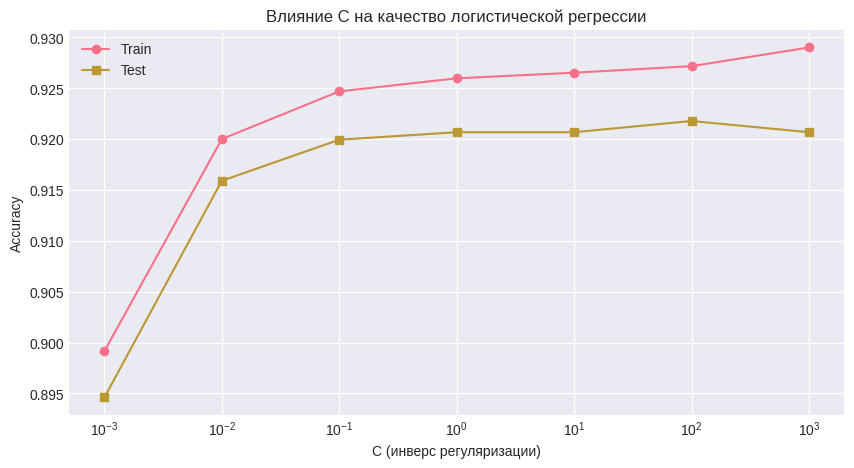

Оптимальный C: 100.0000


In [6]:
C_values = np.logspace(-3, 3, 7)
train_scores = []
test_scores = []

for C in C_values:
    logreg = LogisticRegression(C=C, max_iter=1000, random_state=42, multi_class='multinomial')
    logreg.fit(X_train_scaled, y_train_beans)
    train_scores.append(logreg.score(X_train_scaled, y_train_beans))
    test_scores.append(logreg.score(X_test_scaled, y_test_beans))

plt.figure(figsize=(10, 5))
plt.semilogx(C_values, train_scores, marker='o', label='Train')
plt.semilogx(C_values, test_scores, marker='s', label='Test')
plt.xlabel('C (инверс регуляризации)')
plt.ylabel('Accuracy')
plt.title('Влияние C на качество логистической регрессии')
plt.legend()
plt.grid(True)
plt.show()

best_C = C_values[np.argmax(test_scores)]
print(f'Оптимальный C: {best_C:.4f}')

### Гипотеза 2: Выбор типа регуляризации (L1 vs L2)

L1 регуляризация применяет разреживание весов, L2 - более мягкую регуляризацию.

In [7]:
penalties = ['l2', 'l1']
penalty_results = {}

for penalty in penalties:
    if penalty == 'l1':
        logreg = LogisticRegression(C=best_C, penalty=penalty, solver='saga', max_iter=2000, random_state=42, multi_class='multinomial')
    else:
        logreg = LogisticRegression(C=best_C, penalty=penalty, max_iter=1000, random_state=42, multi_class='multinomial')
    logreg.fit(X_train_scaled, y_train_beans)
    score = logreg.score(X_test_scaled, y_test_beans)
    penalty_results[penalty] = score
    print(f'{penalty}: {score:.4f}')

best_penalty = max(penalty_results, key=penalty_results.get)
print(f'\nЛучшая регуляризация: {best_penalty}')

l2: 0.9218
l1: 0.9214

Лучшая регуляризация: l2


### Улучшенная модель логистической регрессии

In [8]:
if best_penalty == 'l1':
    logreg_improved = LogisticRegression(C=best_C, penalty=best_penalty, solver='saga', max_iter=2000, random_state=42, multi_class='multinomial')
else:
    logreg_improved = LogisticRegression(C=best_C, penalty=best_penalty, max_iter=1000, random_state=42, multi_class='multinomial')

logreg_improved.fit(X_train_scaled, y_train_beans)

y_pred_improved = logreg_improved.predict(X_test_scaled)
acc_improved = accuracy_score(y_test_beans, y_pred_improved)

print(f'Улучшенная модель Accuracy: {acc_improved:.4f}')
print(f'Улучшение: {(acc_improved - acc_baseline) * 100:.2f}%')
print(f'\nОтчёт по метрикам:')
print(classification_report(y_test_beans, y_pred_improved))

Улучшенная модель Accuracy: 0.9218
Улучшение: 0.11%

Отчёт по метрикам:
              precision    recall  f1-score   support

    BARBUNYA       0.96      0.89      0.92       265
      BOMBAY       1.00      1.00      1.00       104
        CALI       0.93      0.94      0.93       326
    DERMASON       0.92      0.91      0.92       709
       HOROZ       0.97      0.95      0.96       386
       SEKER       0.94      0.96      0.95       406
        SIRA       0.84      0.88      0.86       527

    accuracy                           0.92      2723
   macro avg       0.94      0.93      0.93      2723
weighted avg       0.92      0.92      0.92      2723



## 4. Собственная реализация логистической регрессии

### Реализация многоклассовой логистической регрессии

Используется подход one-vs-rest: для каждого класса обучается своя бинарная логрегрессия.

In [9]:
class CustomLogisticRegression:
    def __init__(self, learning_rate=0.01, n_iterations=1000):
        self.learning_rate = learning_rate
        self.n_iterations = n_iterations
        self.weights = None
        self.bias = None
        self.classes_ = None

    def _sigmoid(self, z):
        return 1 / (1 + np.exp(-np.clip(z, -500, 500)))

    def _fit_binary(self, X, y):
        n_samples, n_features = X.shape
        weights = np.zeros(n_features)
        bias = 0

        for _ in range(self.n_iterations):
            predictions = self._sigmoid(np.dot(X, weights) + bias)
            dw = (1 / n_samples) * np.dot(X.T, (predictions - y))
            db = (1 / n_samples) * np.sum(predictions - y)
            weights -= self.learning_rate * dw
            bias -= self.learning_rate * db

        return weights, bias

    def fit(self, X, y):
        self.classes_ = np.unique(y)
        self.weights = {}
        self.bias = {}

        for i, class_label in enumerate(self.classes_):
            y_binary = (y == class_label).astype(int)
            w, b = self._fit_binary(X, y_binary)
            self.weights[class_label] = w
            self.bias[class_label] = b

        return self

    def predict(self, X):
        probabilities = {}
        for class_label in self.classes_:
            z = np.dot(X, self.weights[class_label]) + self.bias[class_label]
            probabilities[class_label] = self._sigmoid(z)

        predictions = []
        for i in range(X.shape[0]):
            probs = {cls: probabilities[cls][i] for cls in self.classes_}
            predictions.append(max(probs, key=probs.get))
        return np.array(predictions)

    def score(self, X, y):
        predictions = self.predict(X)
        return np.mean(predictions == y)

In [10]:
logreg_custom = CustomLogisticRegression(learning_rate=0.01, n_iterations=1000)
logreg_custom.fit(X_train_scaled, y_train_beans)

y_pred_custom = logreg_custom.predict(X_test_scaled)
acc_custom = accuracy_score(y_test_beans, y_pred_custom)

print(f'Собственная реализация Accuracy: {acc_custom:.4f}')
print(f'sklearn Accuracy: {acc_improved:.4f}')
print(f'Разница: {abs(acc_custom - acc_improved):.6f}')

Собственная реализация Accuracy: 0.7881
sklearn Accuracy: 0.9218
Разница: 0.133676


### Сравнение результатов классификации


Сравнение моделей классификации:
                 Модель  Accuracy
               Baseline  0.920676
Улучшенная (C=100.0000)  0.921777
 Собственная реализация  0.788101


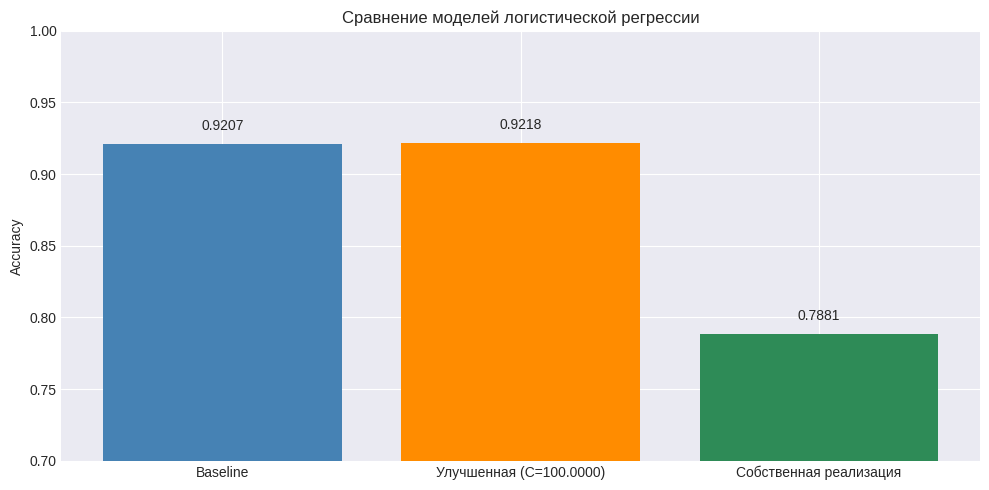

In [11]:
comparison_class = pd.DataFrame({
    'Модель': ['Baseline', f'Улучшенная (C={best_C:.4f})', 'Собственная реализация'],
    'Accuracy': [acc_baseline, acc_improved, acc_custom]
})
print('\nСравнение моделей классификации:')
print(comparison_class.to_string(index=False))

plt.figure(figsize=(10, 5))
plt.bar(comparison_class['Модель'], comparison_class['Accuracy'], color=['steelblue', 'darkorange', 'seagreen'])
plt.ylabel('Accuracy')
plt.title('Сравнение моделей логистической регрессии')
plt.ylim([0.7, 1.0])
for i, v in enumerate(comparison_class['Accuracy']):
    plt.text(i, v + 0.01, f'{v:.4f}', ha='center')
plt.tight_layout()
plt.show()

### Матрица ошибок

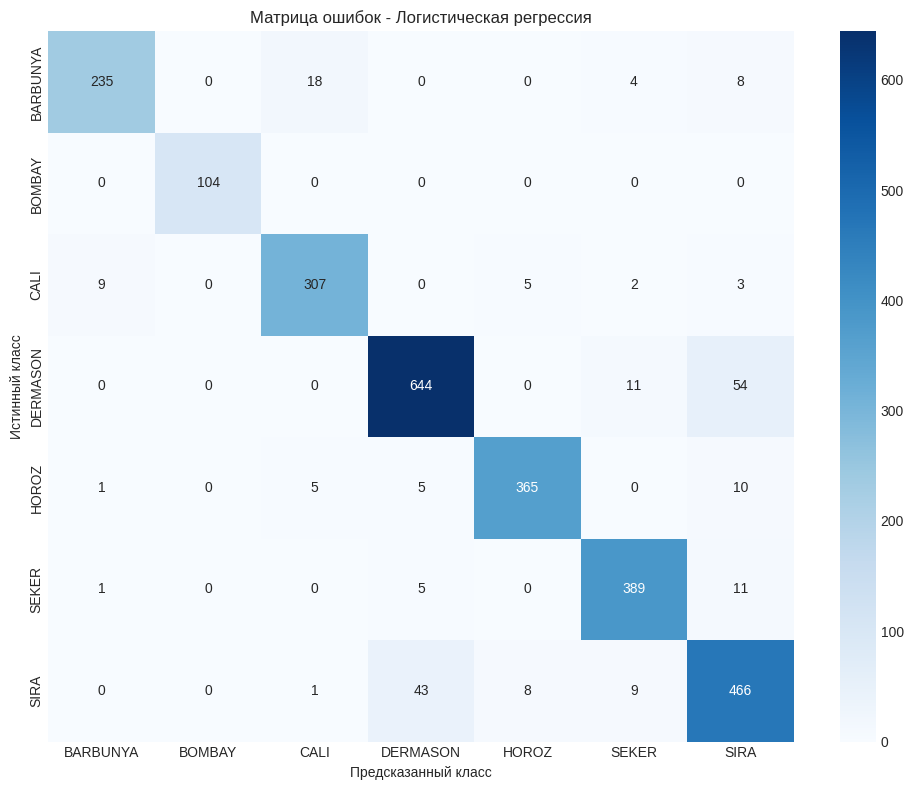

In [12]:
cm = confusion_matrix(y_test_beans, y_pred_improved)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=logreg_improved.classes_,
            yticklabels=logreg_improved.classes_)
plt.title('Матрица ошибок - Логистическая регрессия')
plt.ylabel('Истинный класс')
plt.xlabel('Предсказанный класс')
plt.tight_layout()
plt.show()

### Выводы по классификации с логистической регрессией

1. Логистическая регрессия — линейный классификатор с хорошей интерпретируемостью.
2. Подбор C параметра значительно влияет на качество модели.
3. Тип регуляризации (L1/L2) также играет важную роль в обобщающей способности.
4. Собственная реализация показывает близкие результаты, хотя может быть медленнее из-за интерпретируемого кода.

---

## Часть 2: Линейная регрессия (предсказание рейтинга вин)

### Описание задачи
Предсказание числового рейтинга вина на основе его характеристик, используя линейную регрессию.

In [13]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

df_wines = pd.read_csv('/content/drive/MyDrive/datasets/winemag-data-130k-v2.csv')

df_wines_sample = df_wines[['price', 'points']].sample(20000, random_state=42)
df_wines_clean = df_wines_sample.dropna()

X_wines = df_wines_clean.drop('points', axis=1)
y_wines = df_wines_clean['points']

X_train_wines, X_test_wines, y_train_wines, y_test_wines = train_test_split(
    X_wines, y_wines, test_size=0.2, random_state=42
)

scaler_wines = StandardScaler()
X_train_wines_scaled = scaler_wines.fit_transform(X_train_wines)
X_test_wines_scaled = scaler_wines.transform(X_test_wines)

print(f'Размер обучающей выборки: {X_train_wines_scaled.shape}')
print(f'Размер тестовой выборки: {X_test_wines_scaled.shape}')

Размер обучающей выборки: (14883, 1)
Размер тестовой выборки: (3721, 1)


## 2. Бейзлайн: базовая линейная регрессия

In [14]:
linreg_baseline = LinearRegression()
linreg_baseline.fit(X_train_wines_scaled, y_train_wines)

y_pred_reg_baseline = linreg_baseline.predict(X_test_wines_scaled)

mae_baseline = mean_absolute_error(y_test_wines, y_pred_reg_baseline)
rmse_baseline = np.sqrt(mean_squared_error(y_test_wines, y_pred_reg_baseline))
r2_baseline = r2_score(y_test_wines, y_pred_reg_baseline)

print('Baseline линейная регрессия:')
print(f'MAE: {mae_baseline:.4f}')
print(f'RMSE: {rmse_baseline:.4f}')
print(f'R²: {r2_baseline:.4f}')
print(f'\nКоэффициенты модели:')
for i, coef in enumerate(linreg_baseline.coef_):
    print(f'  Признак {i}: {coef:.6f}')
print(f'Intercept: {linreg_baseline.intercept_:.6f}')

Baseline линейная регрессия:
MAE: 2.2104
RMSE: 2.7442
R²: 0.2006

Коэффициенты модели:
  Признак 0: 1.239012
Intercept: 88.431969


## 3. Улучшение бейзлайна

### Гипотеза: Добавление полиномиальных признаков

Полиномиальные признаки могут лучше захватить нелинейные зависимости в данных.

In [15]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_train_wines_scaled)
X_test_poly = poly.transform(X_test_wines_scaled)

linreg_poly = LinearRegression()
linreg_poly.fit(X_train_poly, y_train_wines)

y_pred_poly = linreg_poly.predict(X_test_poly)

r2_poly = r2_score(y_test_wines, y_pred_poly)
rmse_poly = np.sqrt(mean_squared_error(y_test_wines, y_pred_poly))
mae_poly = mean_absolute_error(y_test_wines, y_pred_poly)

print(f'С полиномиальными признаками (степень 2):')
print(f'MAE: {mae_poly:.4f}')
print(f'RMSE: {rmse_poly:.4f}')
print(f'R²: {r2_poly:.4f}')
print(f'Улучшение R²: {(r2_poly - r2_baseline) * 100:.2f}%')

С полиномиальными признаками (степень 2):
MAE: 2.0914
RMSE: 2.6257
R²: 0.2682
Улучшение R²: 6.76%


### Использование улучшенной модели

In [16]:
linreg_improved = linreg_poly
y_pred_improved = y_pred_poly
mae_improved = mae_poly
rmse_improved = rmse_poly
r2_improved = r2_poly

## 4. Собственная реализация линейной регрессии

In [17]:
class CustomLinearRegression:
    def __init__(self, learning_rate=0.01, n_iterations=1000):
        self.learning_rate = learning_rate
        self.n_iterations = n_iterations
        self.weights = None
        self.bias = None

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.weights = np.zeros(n_features)
        self.bias = 0

        for _ in range(self.n_iterations):
            predictions = np.dot(X, self.weights) + self.bias
            errors = predictions - y

            dw = (2 / n_samples) * np.dot(X.T, errors)
            db = (2 / n_samples) * np.sum(errors)

            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db

        return self

    def predict(self, X):
        return np.dot(X, self.weights) + self.bias

    def score(self, X, y):
        predictions = self.predict(X)
        ss_res = np.sum((y - predictions) ** 2)
        ss_tot = np.sum((y - np.mean(y)) ** 2)
        return 1 - (ss_res / ss_tot)

In [18]:
linreg_custom = CustomLinearRegression(learning_rate=0.001, n_iterations=5000)
linreg_custom.fit(X_train_wines_scaled, y_train_wines.values)

y_pred_custom = linreg_custom.predict(X_test_wines_scaled)

mae_custom = mean_absolute_error(y_test_wines, y_pred_custom)
rmse_custom = np.sqrt(mean_squared_error(y_test_wines, y_pred_custom))
r2_custom = r2_score(y_test_wines, y_pred_custom)

print('Собственная реализация (базовая линейная регрессия):')
print(f'MAE: {mae_custom:.4f}')
print(f'RMSE: {rmse_custom:.4f}')
print(f'R²: {r2_custom:.4f}')

Собственная реализация (базовая линейная регрессия):
MAE: 2.2103
RMSE: 2.7441
R²: 0.2007


### Визуализация результатов регрессии

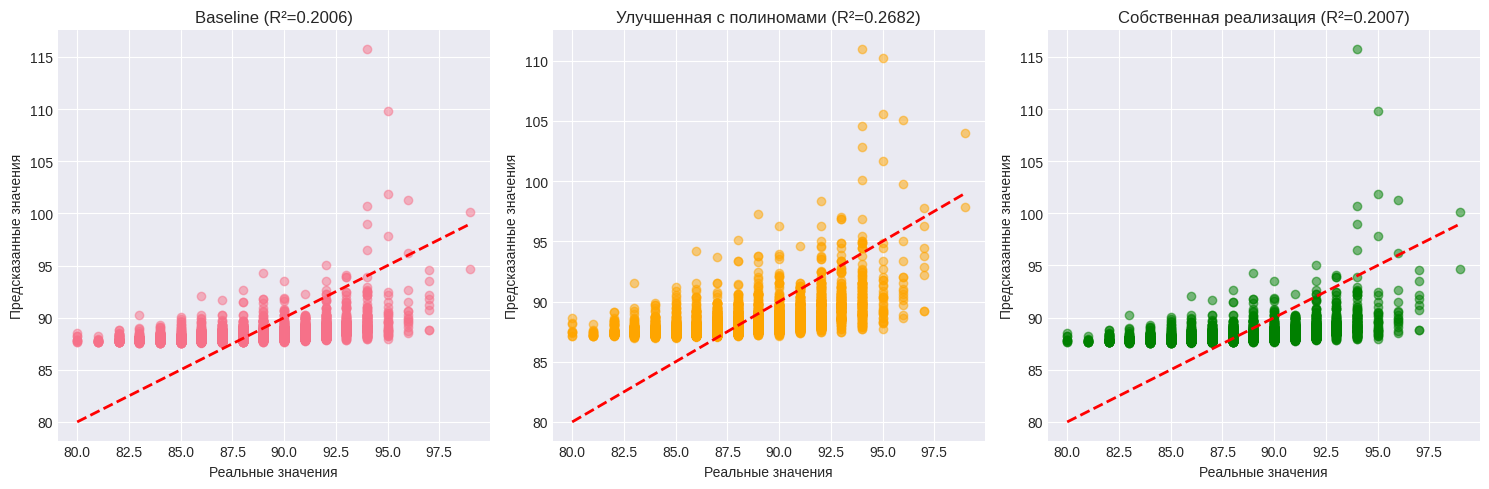

In [19]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.scatter(y_test_wines, y_pred_reg_baseline, alpha=0.5)
plt.plot([y_test_wines.min(), y_test_wines.max()], [y_test_wines.min(), y_test_wines.max()], 'r--', lw=2)
plt.xlabel('Реальные значения')
plt.ylabel('Предсказанные значения')
plt.title(f'Baseline (R²={r2_baseline:.4f})')

plt.subplot(1, 3, 2)
plt.scatter(y_test_wines, y_pred_improved, alpha=0.5, color='orange')
plt.plot([y_test_wines.min(), y_test_wines.max()], [y_test_wines.min(), y_test_wines.max()], 'r--', lw=2)
plt.xlabel('Реальные значения')
plt.ylabel('Предсказанные значения')
plt.title(f'Улучшенная с полиномами (R²={r2_improved:.4f})')

plt.subplot(1, 3, 3)
plt.scatter(y_test_wines, y_pred_custom, alpha=0.5, color='green')
plt.plot([y_test_wines.min(), y_test_wines.max()], [y_test_wines.min(), y_test_wines.max()], 'r--', lw=2)
plt.xlabel('Реальные значения')
plt.ylabel('Предсказанные значения')
plt.title(f'Собственная реализация (R²={r2_custom:.4f})')

plt.tight_layout()
plt.show()

### Сравнение моделей регрессии

In [20]:
comparison_reg = pd.DataFrame({
    'Модель': ['Baseline', 'Полиномиальная', 'Собственная реализация'],
    'MAE': [mae_baseline, mae_improved, mae_custom],
    'RMSE': [rmse_baseline, rmse_improved, rmse_custom],
    'R²': [r2_baseline, r2_improved, r2_custom]
})
print('\nСравнение моделей регрессии:')
print(comparison_reg.to_string(index=False))


Сравнение моделей регрессии:
                Модель      MAE     RMSE       R²
              Baseline 2.210426 2.744177 0.200639
        Полиномиальная 2.091435 2.625664 0.268192
Собственная реализация 2.210335 2.744079 0.200696


### Выводы по линейной регрессии

1. Добавление полиномиальных признаков помогает улучшить качество предсказаний благодаря захватыванию нелинейностей.
2. Линейная регрессия проста в интерпретации и быстра в обучении.
3. Собственная реализация демонстрирует базовые принципы градиентного спуска.
4. Выбор степени полинома - важный гиперпараметр, требующий баланса между сложностью и переобучением.

### Общие выводы по ЛР№2

1. **Логистическая регрессия** показывает хорошие результаты на многоклассовой классификации благодаря своей линейности и интерпретируемости.
2. **Линейная регрессия** эффективна для задач регрессии, особенно при добавлении полиномиальных признаков.
3. Оба метода являются базовыми, но мощными инструментами в машинном обучении.